In [3]:
"""
Ground Plane Detection
"""

import numpy as np
import matplotlib.pyplot as plt
import random
import math
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import pandas as pd
import sys


In [4]:
class RANSAC:
    """
    RANSAC Class
    """
    def __init__(self, point_cloud, max_iterations, distance_ratio_threshold):
        self.point_cloud = point_cloud
        self.max_iterations = max_iterations
        self.distance_ratio_threshold = distance_ratio_threshold
    #
    def run(self):
        """
        method for running the class directly
        :return:
        """
        inliers, outliers = self._ransac_algorithm(self.max_iterations, self.distance_ratio_threshold)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(inliers.x , inliers.y,  inliers.z,  c="green")
        ax.scatter(outliers.x, outliers.y, outliers.z, c="red")
        plt.show()
        if(outliers.size>0):
            return False
        else:
            return True
        

    def _visualize_point_cloud(self):
        """
        Visualize the 3D data
        :return: None
        """
        # Visualize the point cloud data
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(self.point_cloud.x , self.point_cloud.y, self.point_cloud.z)
        plt.show()

    def _ransac_algorithm(self, max_iterations, distance_ratio_threshold):
        """
        Implementation of the RANSAC logic
        :return: inliers(Dataframe), outliers(Dataframe)
        """

        inliers_result = set()
        while max_iterations:
            max_iterations -= 1
            # Add 3 random indexes
            random.seed()
            inliers = []
            while len(inliers) < 3:
                random_index = random.randint(0, len(self.point_cloud.x)-1)
                inliers.append(random_index)
            # print(inliers)
            try:
                # In case of *.xyz data
                x1, y1, z1, _, _, _ = point_cloud.loc[inliers[0]]
                x2, y2, z2, _, _, _ = point_cloud.loc[inliers[1]]
                x3, y3, z3, _, _, _ = point_cloud.loc[inliers[2]]
            except:
                # In case of *.pcd data
                x1, y1, z1 = point_cloud.loc[inliers[0]]
                x2, y2, z2 = point_cloud.loc[inliers[1]]
                x3, y3, z3 = point_cloud.loc[inliers[2]]
            # Plane Equation --> ax + by + cz + d = 0
            # Value of Constants for inlier plane
            a = (y2 - y1)*(z3 - z1) - (z2 - z1)*(y3 - y1)
            b = (z2 - z1)*(x3 - x1) - (x2 - x1)*(z3 - z1)
            c = (x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 - x1)
            d = -(a*x1 + b*y1 + c*z1)
            plane_lenght = max(0.1, math.sqrt(a*a + b*b + c*c))

            for point in self.point_cloud.iterrows():
                index = point[0]
                # Skip iteration if point matches the randomly generated inlier point
                if index in inliers:
                    continue
                try:
                    # In case of *.xyz data
                    x, y, z, _, _, _ = point[1]
                except:
                    # In case of *.pcd data
                    x, y, z = point[1]

                # Calculate the distance of the point to the inlier plane
                distance = math.fabs(a*x + b*y + c*z + d)/plane_lenght
                # Add the point as inlier, if within the threshold distancec ratio
                if distance <= distance_ratio_threshold:
                    inliers.append(index)
            # Update the set for retaining the maximum number of inlier points
            if len(inliers) > len(inliers_result):
                inliers_result.clear()
                inliers_result = inliers

        # Segregate inliers and outliers from the point cloud
        inlier_points = pd.DataFrame(columns={"x", "y", "z"})
        outlier_points = pd.DataFrame(columns={"x", "y", "z"})
        for point in point_cloud.iterrows():
            if point[0] in inliers_result:
                inlier_points = inlier_points.append({"x": point[1]["x"],
                                                      "y": point[1]["y"],
                                                      "z": point[1]["z"]}, ignore_index=True)
                continue
            outlier_points = outlier_points.append({"x": point[1]["x"],
                                                    "y": point[1]["y"],
                                                    "z": point[1]["z"]}, ignore_index=True)

        return inlier_points, outlier_points

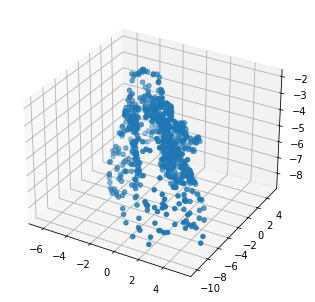

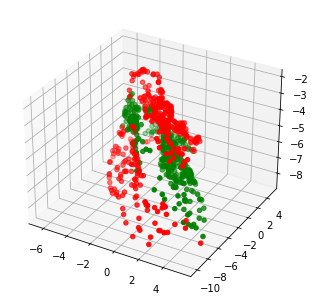

False


In [5]:
#filename = sys.argv[-1]
filename = "test_data/test.xyz"

if __name__ == "__main__":
    # Read the point cloud data
    # point_cloud = pd.read_csv("point_cloud_data_sample.xyz", delimiter=" ", nrows=500)
    pcd = o3d.io.read_point_cloud(filename, format='xyz')
    point_cloud = pd.DataFrame(pcd.points, columns={"x" ,"y" ,"z"})
    APPLICATION = RANSAC(point_cloud, max_iterations=50, distance_ratio_threshold=1)
    APPLICATION._visualize_point_cloud()
    output = APPLICATION.run()
    
    print(output)